<div dir="rtl" align="center">
    <h2><strong> HW1: Overfitting Detection through Validation Set </strong></h2>
</div>

### **Import libraries**

In [1]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from torchmetrics import Accuracy

import numpy as np

import matplotlib.pyplot as plt

### **Load train and test FasionMNIST dataset**

In [2]:
BATCH_size = 64

In [3]:
train_data = datasets.FashionMNIST(
    root="./Data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="./Data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_size,
    shuffle=True,
)

### **Construct Multi-Layer Neural Network Model**

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28**2, 64),
            nn.ReLU(),
            
            nn.Linear(64, 128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        z = self.linear_layer(x)
        return z

### **Define Criterion and Optimizer**

the loss and optimizer are defined in the next section

In [6]:
LEARNING_RATE = 0.0003
EPOCHS = 20

### **Training & Evaluating NN Model**

In [7]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cpu' # we choose cpu for this model
device

'cpu'

In [8]:
model = MLP().to(device)

# defining the optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
accuracy_fn = Accuracy(task="multiclass", num_classes=10)


train_loss_values, train_acc_values = [], []
test_loss_values, test_acc_values = [], []

for epoch in range(EPOCHS):
    train_batch_loss = 0
    train_batch_acc = 0

    for batch, (image, label) in enumerate(train_dataloader):
        image = image.to(device)
        label = label.to(device)
        
        model.train()
        logits = model(image)
        train_loss = loss_fn(logits, label)
        y_pred = nn.Softmax(dim=1)(logits).argmax(dim=1)


        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_batch_loss += train_loss.item()
        train_batch_acc += accuracy_fn(label, y_pred).item()

    train_loss_values.append(train_batch_loss / batch)
    train_acc_values.append(train_batch_acc / batch)

    test_batch_loss = 0
    test_batch_acc = 0
    model.eval()
    with torch.inference_mode():
        for batch, (image, label) in enumerate(test_dataloader):
            image = image.to(device)
            label = label.to(device)
            
            test_logits = model(image)
            test_loss = loss_fn(test_logits, label)
            test_y_pred = nn.Softmax(dim=1)(test_logits).argmax(dim=1)

            test_batch_loss += test_loss.item()
            test_batch_acc += accuracy_fn(label, test_y_pred).item()
            
        test_loss_values.append(test_batch_loss / batch)
        test_acc_values.append(test_batch_acc / batch)

    print("EPOCH:", epoch)
    print('train-loss', train_loss_values[epoch], end=" || ")
    print("train-acc", train_acc_values[epoch])
    print("test-loss", test_loss_values[epoch], end=" || ")
    print("test-acc", test_acc_values[epoch], end="\n\n")


EPOCH: 0
train-loss 0.7371566900257877 || train-acc 0.7248699306296692
test-loss 0.5758896397474484 || test-acc 0.8042868589743589

EPOCH: 1
train-loss 0.4824396713279991 || train-acc 0.8287253201707577
test-loss 0.4693947924444309 || test-acc 0.8373397435897436

EPOCH: 2
train-loss 0.4234547585789651 || train-acc 0.8490028014941302
test-loss 0.44887495642671216 || test-acc 0.8425480769230769

EPOCH: 3
train-loss 0.3800257106918917 || train-acc 0.8624099519743863
test-loss 0.42973524819199854 || test-acc 0.8493589743589743

EPOCH: 4
train-loss 0.35661172153569337 || train-acc 0.8707644076840982
test-loss 0.40739890933036804 || test-acc 0.8559695512820513

EPOCH: 5
train-loss 0.336465196379857 || train-acc 0.8769343649946638
test-loss 0.38629406919846165 || test-acc 0.8656850961538461

EPOCH: 6
train-loss 0.32169756338620514 || train-acc 0.8836212646744931
test-loss 0.40308677051693964 || test-acc 0.856270032051282

EPOCH: 7
train-loss 0.3090052806485043 || train-acc 0.8875900480256137


### **Plot train and validation losses**

In [9]:
def learning_curve_plotter(train_loss_values, test_loss_values, EPOCH) :
    # plot the learning curves
    plt.plot(np.arange(1, EPOCH+1), train_loss_values, label="Train loss")
    plt.plot(np.arange(1, EPOCH+1), test_loss_values, label="Test loss")
    plt.title("Training and test loss curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend();

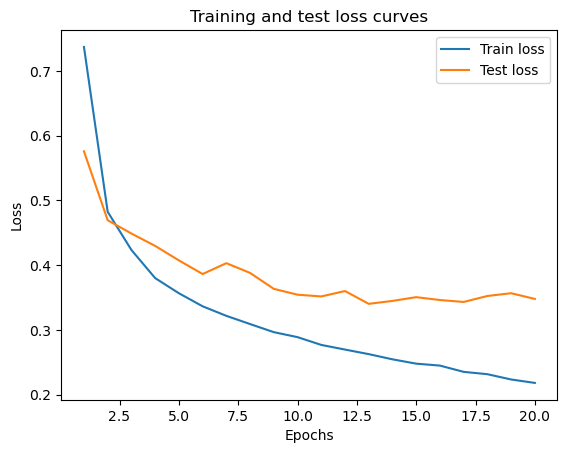

In [10]:
learning_curve_plotter(train_loss_values, test_loss_values, EPOCHS)

obviously, we are having overfitting problem!